# How to use `contaminante`

This tutorial will show you how to use `contaminante`. If you'd like to try it yourself, you can use `contaminante` online, in the cloud, for free! Click [here](https://colab.research.google.com/github/christinahedges/contaminante/blob/master/tutorials/Colaboratory-Notebook.ipynb) to run `contaminante` online using Google's Colaboratory. 

## Using `contaminante` on *Kepler* data

To demonstrate `contaminante` we'll first use *Kepler* data. First we'll need a target to try `contaminante` on. I've chosen *KIC 6804648*. This target was observed during the prime *Kepler* mission, and was flagged as a planet candidate. In fact, the target has a contaminating eclipsing binary. This binary is only obvious in some of the *Kepler* quarters. 

Below we run the target through `contaminante`. Running this cell should take less than 5 minutes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import contaminante as ct
import lightkurve as lk

In [3]:
lk.__version__

'2.0.9'

In [4]:
tpfs = lk.search_targetpixelfile('KIC 6804648', quarter=[10, 11, 12]).download_all()
period = 0.700606
t0 = 131.59767
duration = 0.993/24

Modeling TPFs:   0%|          | 0/3 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:268: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs:  33%|███▎      | 1/3 [00:06<00:12,  6.12s/it]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:268: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs:  67%|██████▋   | 2/3 [00:11<00:05,  5.84s/it]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:268: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 3/3 [00:16<00:00,  5.54s/it]


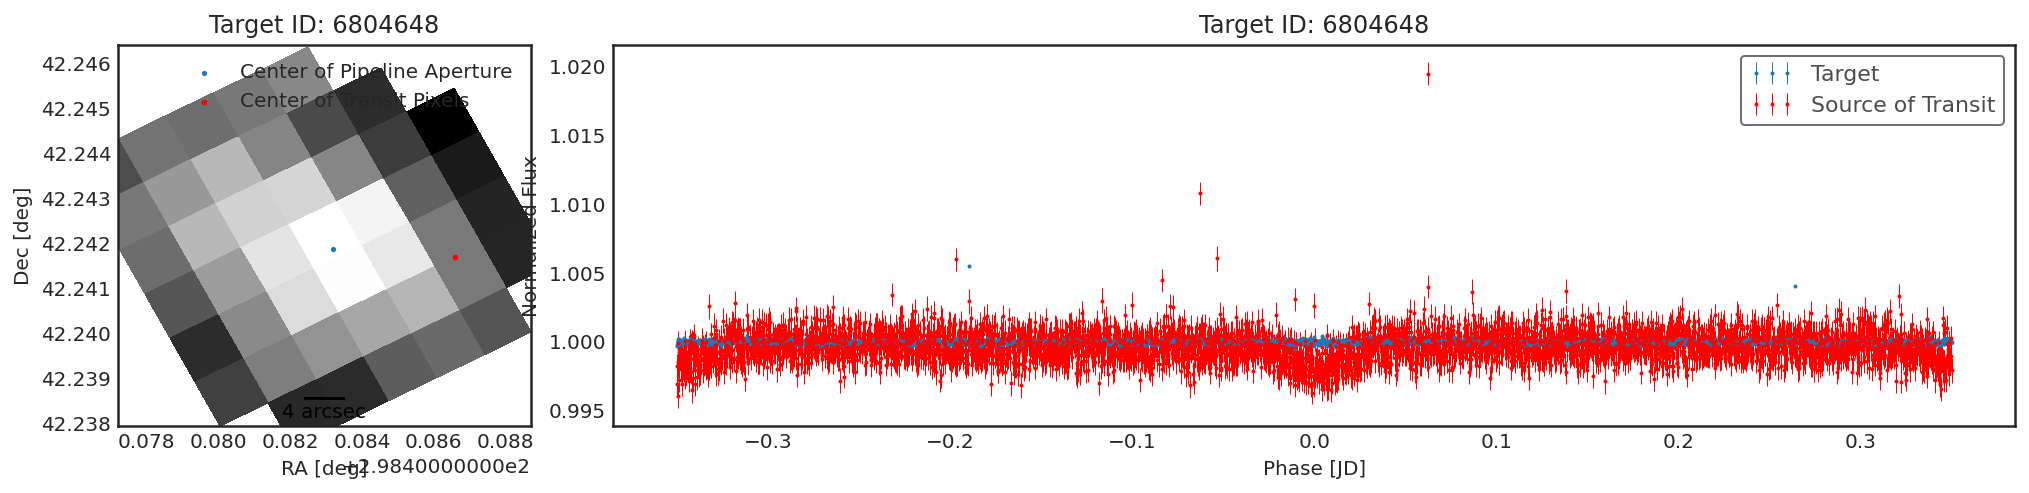

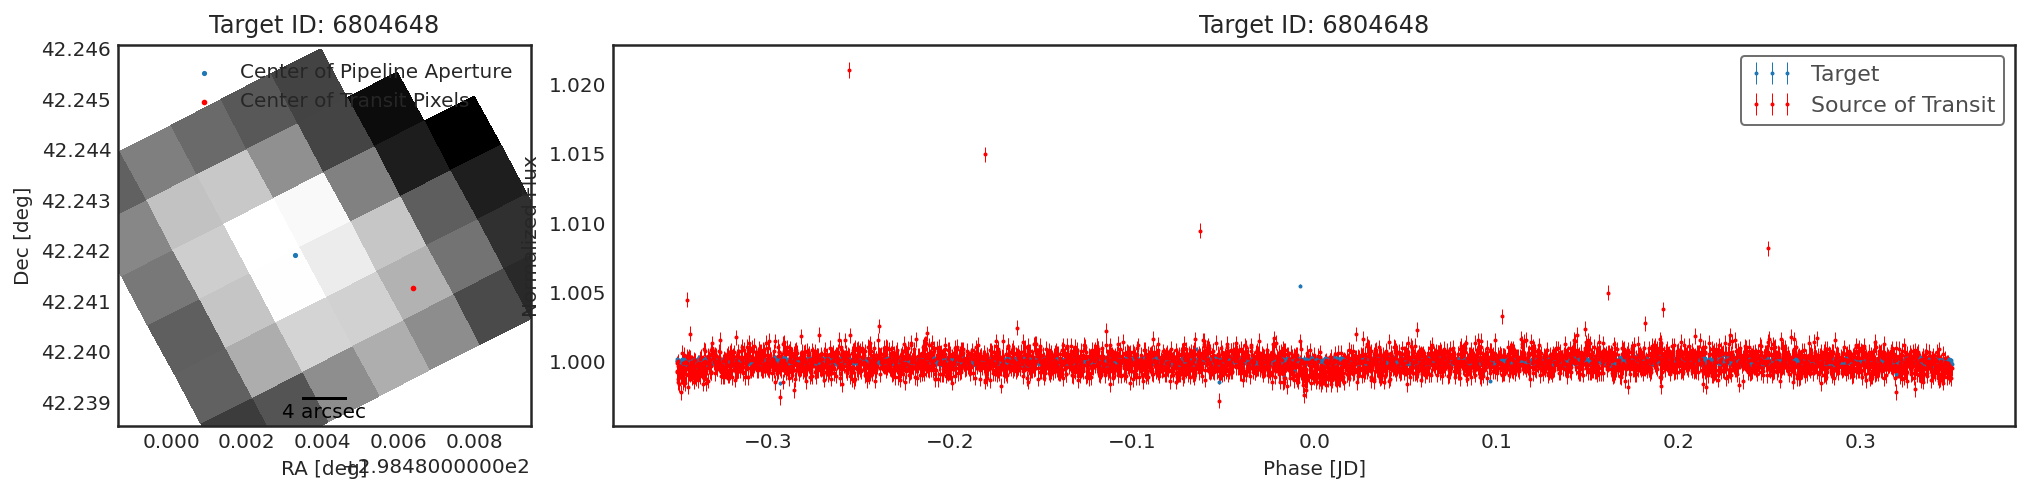

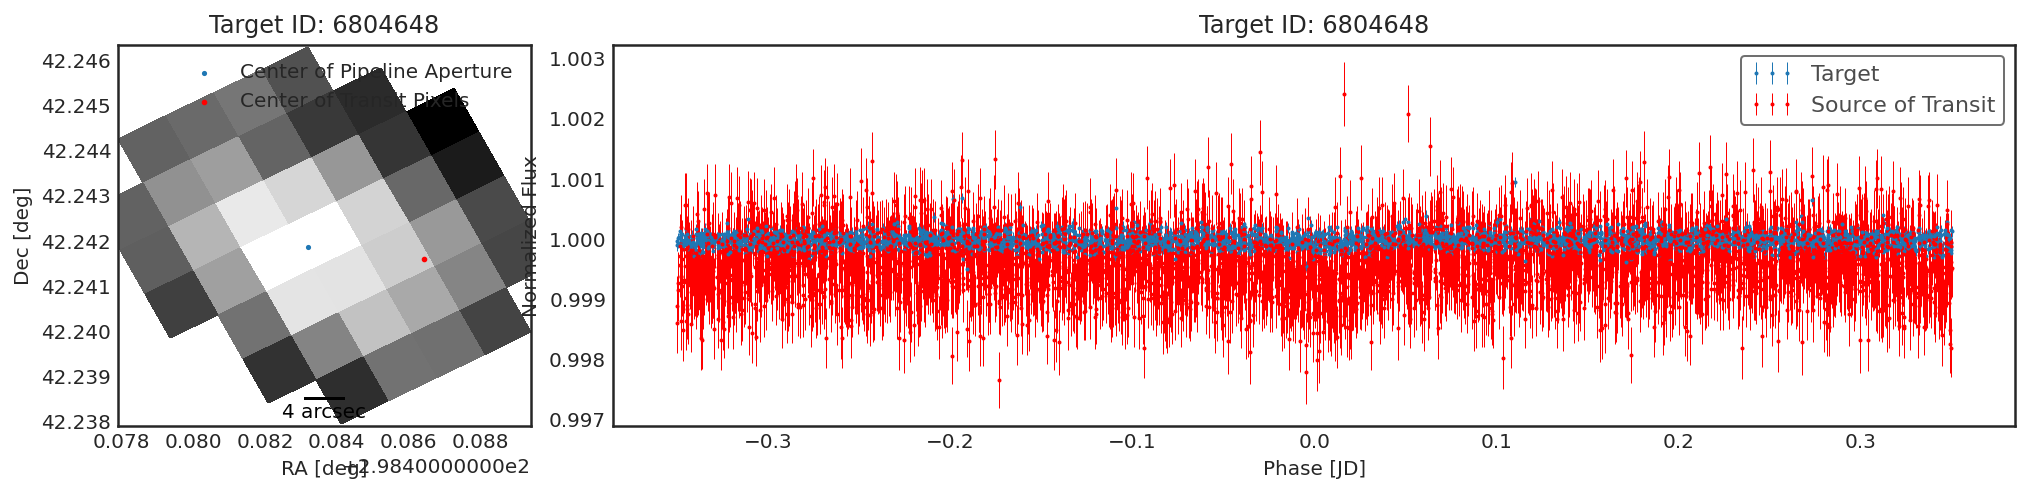

In [19]:
result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True, sff=False, spline_period=0.5, cbvs=True);

Using `contaminante` we can see two pieces of evidence that this target is contaminated.
1. There is a significant offset between the center of the **target** (blue dot) in the image, and the **source of the transiting signal** (red dot). **NOTE: The blue dot is the weighted average of the flux inside the pipeline aperture, for crowded sources this may not be accurate.**
2. There is a significant difference between the **target** phase curve (blue phase curve) and the **source of the transiting signal** phase curve (red phase curve).

We name the source of the transiting signal that `contaminante` finds the "contaminator".

The result is a list of dictionaries contains the depth and positions of the target and the "contamintor" for each quarter, including errors. The user is encouraged to 1) look at the phase curves 2) look at the positions of the contaminator and target and 3) the transit depths of the contaminator and the target before claiming that a target is contaminated. In the above cases there is a significant difference between the contaminator and the target.

To compare, we can look at a target that is a true, confirmed planet. Below I run the parameters for **Kepler-10** through `contaminate`.

Modeling TPFs:   0%|          | 0/2 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:268: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs:  50%|█████     | 1/2 [00:08<00:08,  8.92s/it]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:268: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 2/2 [00:16<00:00,  8.20s/it]


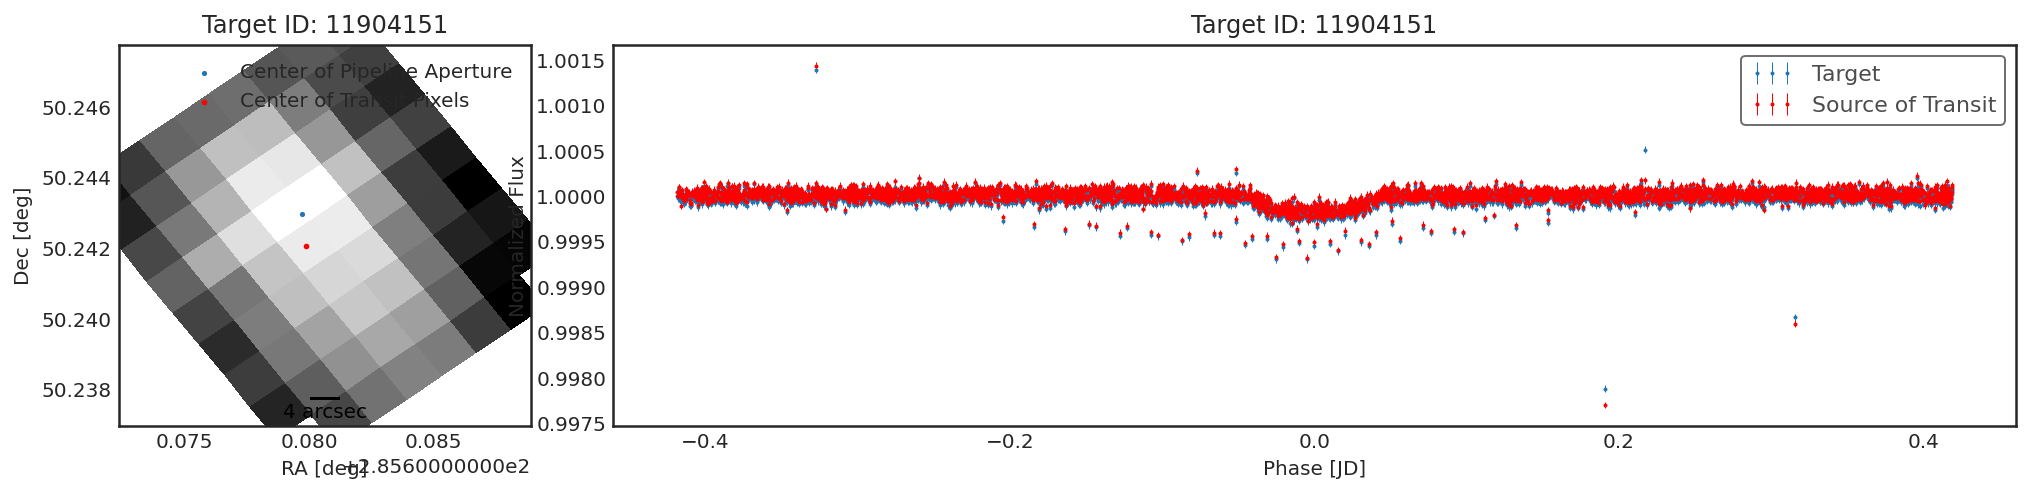

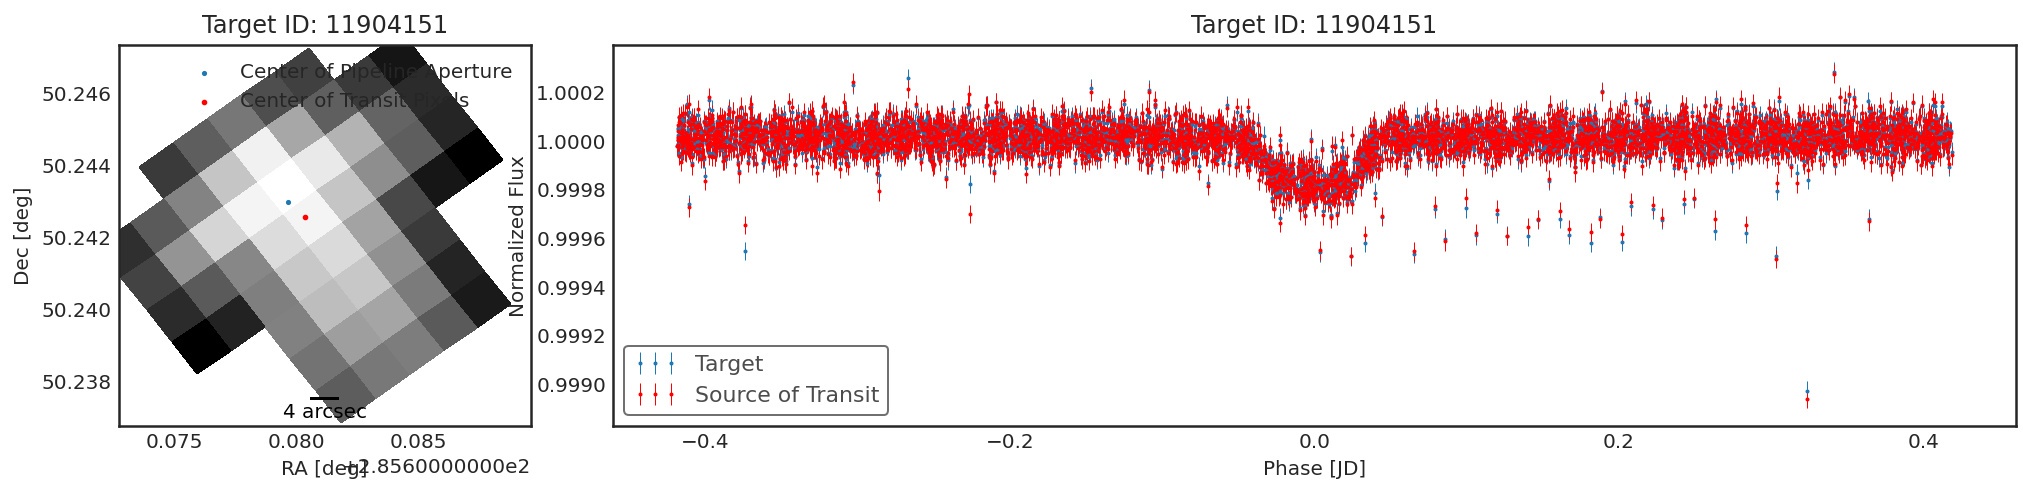

In [23]:
tpfs = lk.search_targetpixelfile('Kepler-10', quarter=[10, 11], cadence='long', mission='Kepler').download_all()
period = 0.837491
t0 = 2454964.57513 - 2454833
duration = 1.8076/24

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True);

Sometimes there will be no significant transiting source that was not the target, and so the `contaminator` and `target` fields will be very similar. Sometimes there will be a weak detection due to a slight difference in optimal aperture. If there is only a small change in centroid ($<<$ than a pixel width) and only a small change in transit depth, this would indicate there is no contaminant.

## Using `contaminante` on *TESS* Data

`contaminante` works on TESS data too. We don't currently have a way to remove TESS background, so make sure to pass in TPFs that have already been background corrected.

/Users/ch/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
Modeling TPFs:   0%|          | 0/1 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:465: RuntimeWarning: invalid value encountered in log10
  ylim[1] = np.max([np.percentile(dec, 99), ylim[1]])
Modeling TPFs: 100%|██████████| 1/1 [00:47<00:00, 47.63s/it]


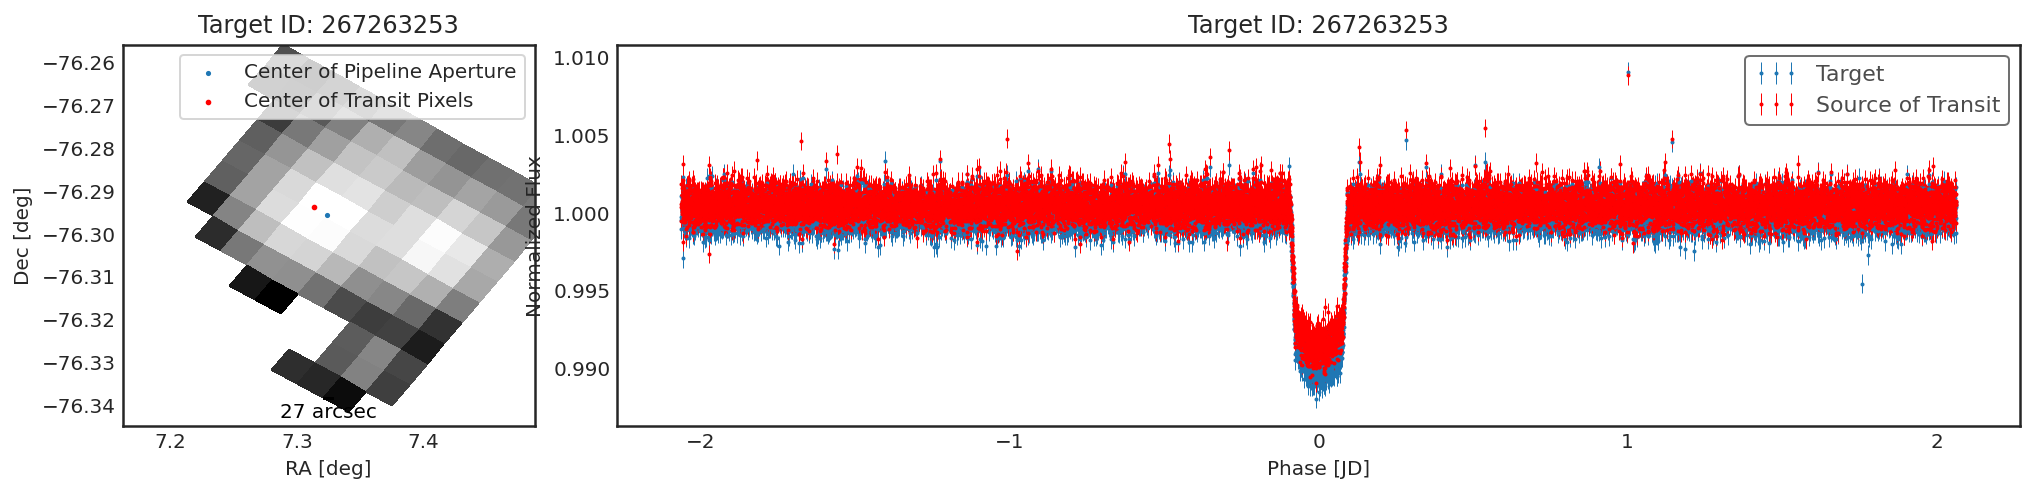

In [28]:
# TESS Data
tpfs = lk.search_targetpixelfile('TIC 267263253', sector=1).download()
period = 4.12688
t0 = 2458325.78297 - 2457000
duration = 0.3

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True);

In this case, it looks like there is a small offset, however the transit depth from contaminante is actually shallower. The aperture selected by `contaminante` is quite large, we can see this when we plot the two apertures side by side:

[Text(0.5, 1.0, '`contaminante` Aperture'), [], []]

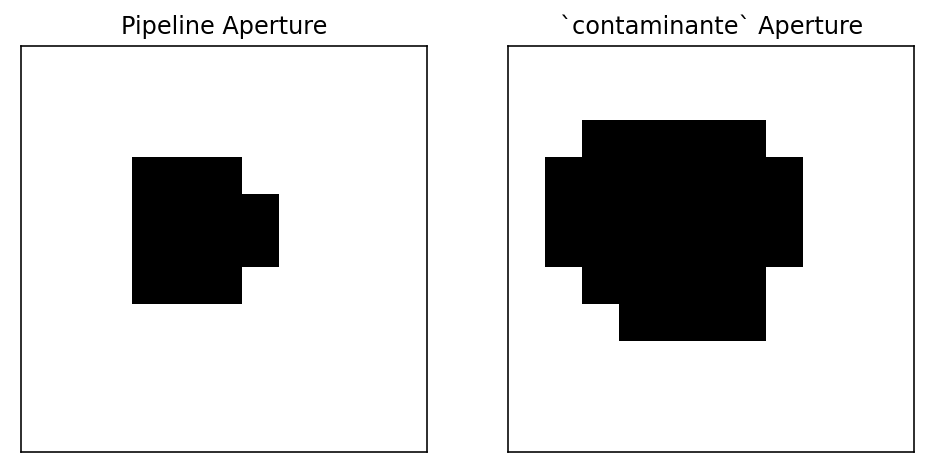

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(result[0]['target_aper'], cmap='Greys')
ax[1].imshow(result[0]['contaminator_aper'], cmap='Greys')
ax[0].set(title='Pipeline Aperture', xticks=[], yticks=[])
ax[1].set(title='`contaminante` Aperture', xticks=[], yticks=[])

This causes `contaminante` to produce a slightly shallower transit (because we're including more noise and flux from  objects that aren't the target). Because the transit depth is shallower, even though there is a small offset, we shouldn't believe this is a contaminant. 

If you want to see more of where the transit is coming from, you can look at the transit depth in each pixel.

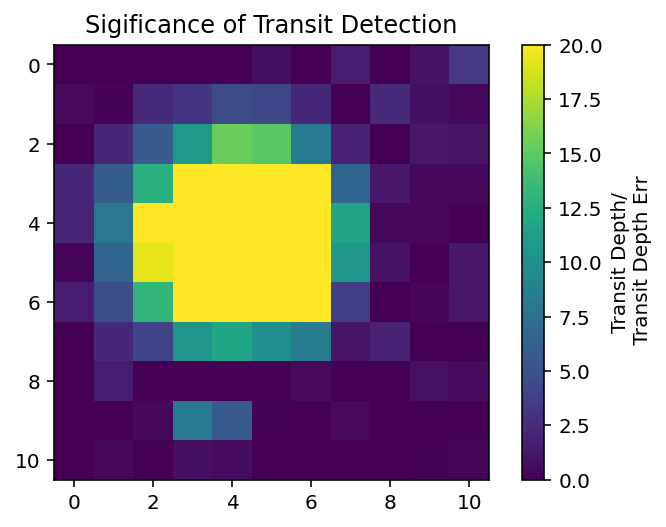

In [29]:
plt.imshow(result[0]['transit_depth']/result[0]['transit_depth_err'], vmin=0, vmax=20)
plt.title("Sigificance of Transit Detection")
cbar = plt.colorbar()
cbar.set_label("Transit Depth/\n Transit Depth Err")

## Using `contaminante` on *K2* Data

`contaminante` works on K2 data too. The motion noise is removed using a similar approach to the Self Flat Fielding technique used in `lightkurve`. Because of the K2 motion the results may be a little harder to interpret. For example, below there is a slight shift in the centroid, but the light curve from that target is not different from the main target. This is likely due to the pipeline apertures for K2 being slightly too small.

Below are a couple of examples of the tool running on K2 data

Modeling TPFs:   0%|          | 0/3 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:279: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs:  33%|███▎      | 1/3 [00:10<00:20, 10.23s/it]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:279: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs:  67%|██████▋   | 2/3 [00:26<00:13, 13.57s/it]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:279: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 3/3 [00:34<00:00, 11.43s/it]


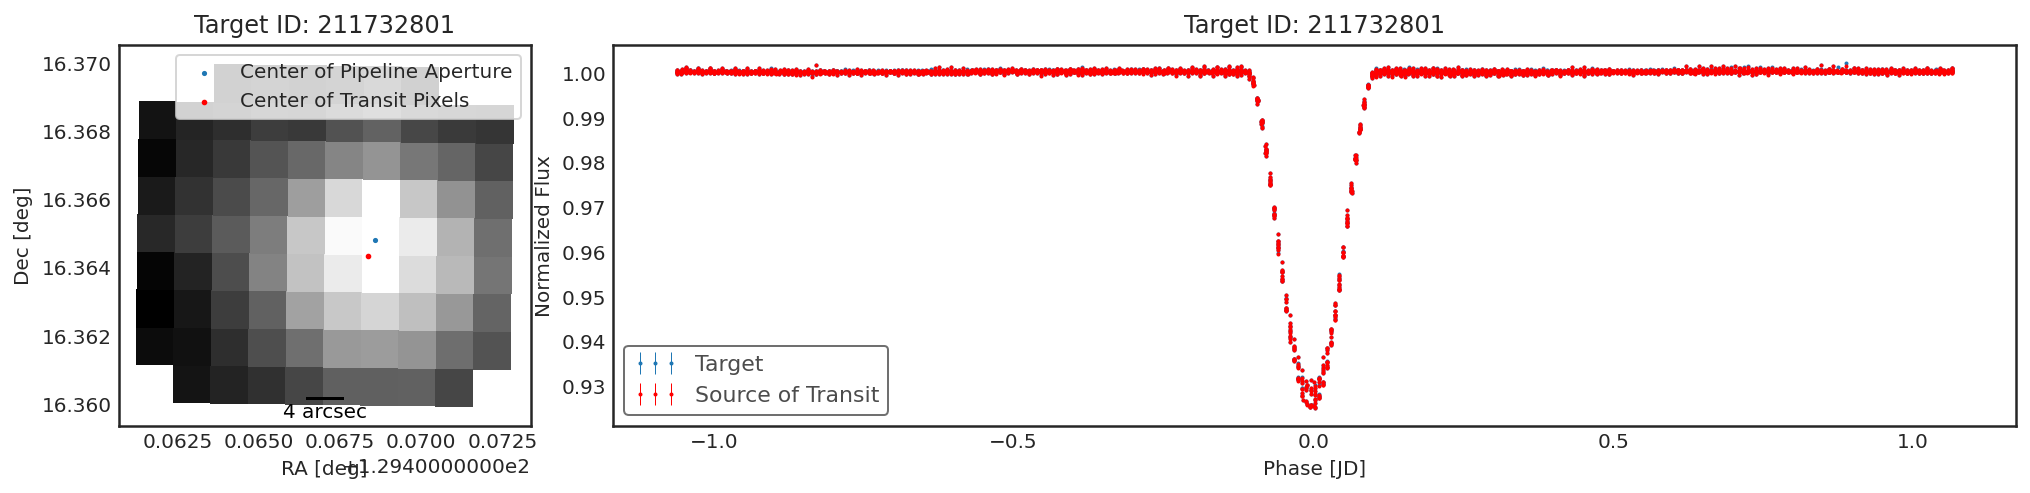

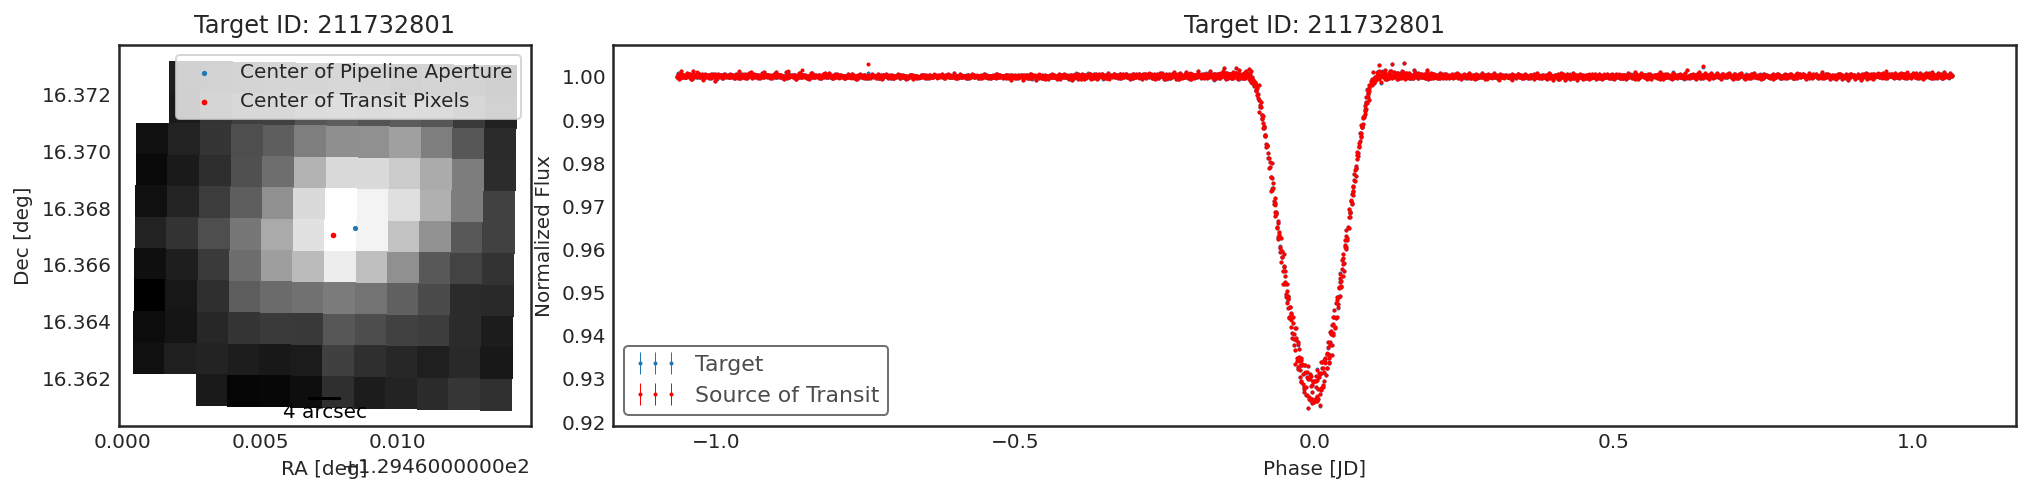

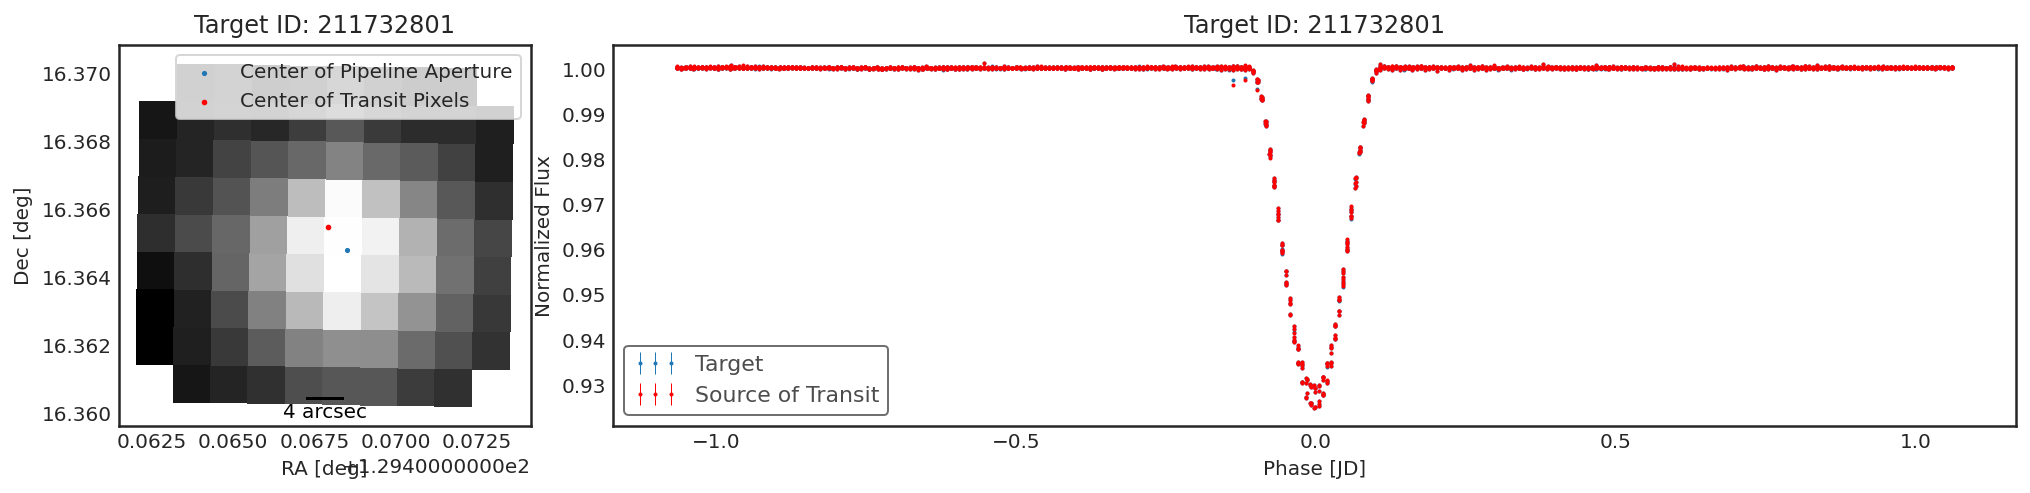

In [43]:
tpfs = lk.search_targetpixelfile("EPIC 211732801").download_all()
period = 2.1316925
t0 = 2308.407161
duration = 0.3

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True, sff=True);

Modeling TPFs:   0%|          | 0/1 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:277: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 1/1 [00:09<00:00,  9.93s/it]


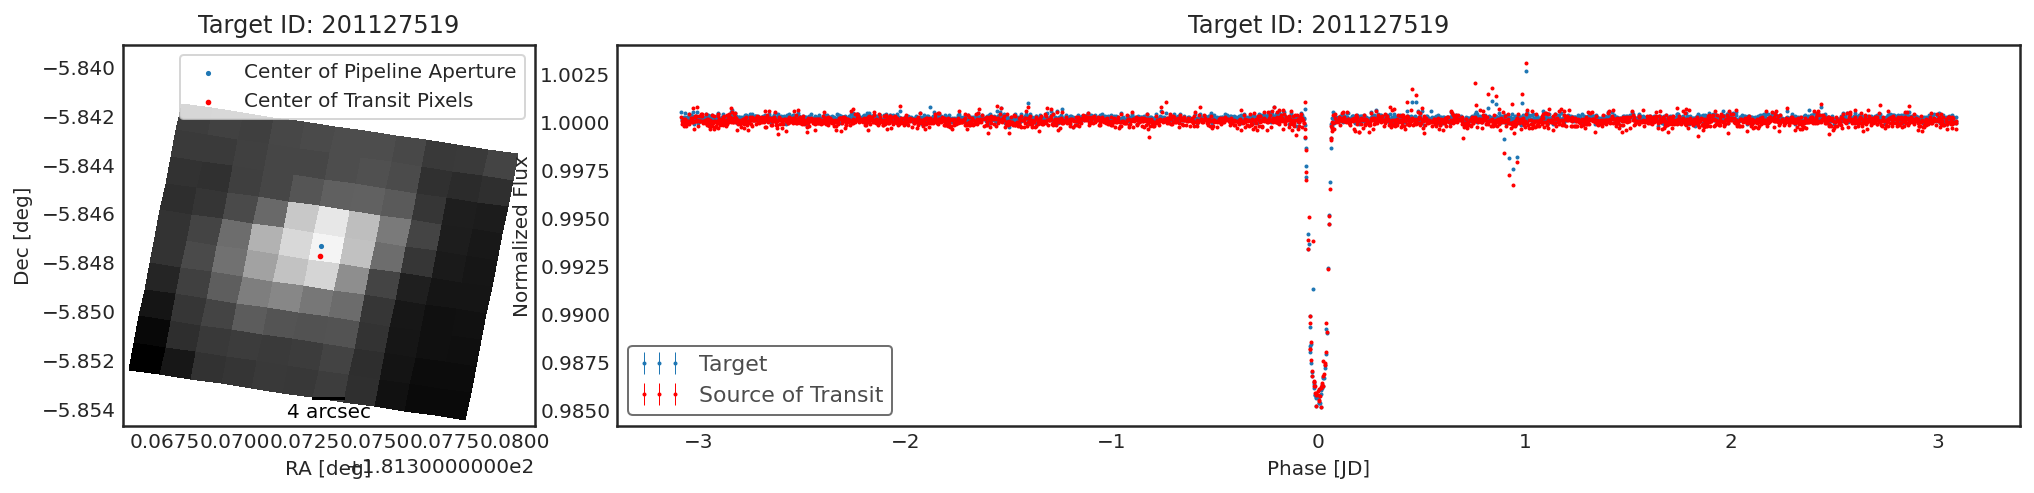

In [33]:
tpfs = lk.search_targetpixelfile("EPIC 201127519").download_all()[1:]
period = 6.178369
t0 = 2457585.55131 - 2454833
duration = 0.1

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True, sff=True);

`contaminante` does try to produce reasonable results for saturated targets, but especially for K2 this can be quite hard.

Modeling TPFs:   0%|          | 0/1 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:278: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 1/1 [00:20<00:00, 20.20s/it]


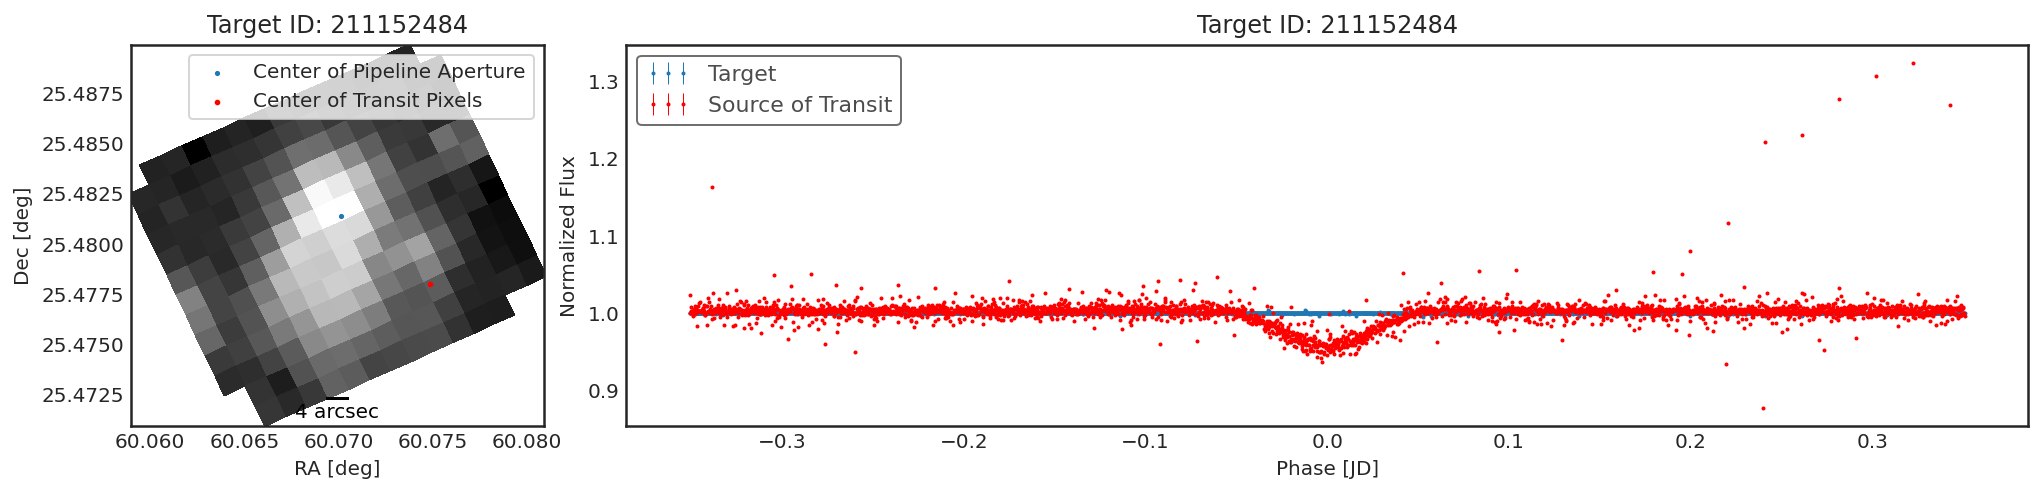

In [39]:
tpfs = lk.search_targetpixelfile("K2-92").download_all()
period = 0.7018484
t0 = 2229.0703797
duration = 0.05
result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True, sff=True, windows=20, bins=15, spline_period=1.5, cbvs=True);

Modeling TPFs:   0%|          | 0/1 [00:00<?, ?it/s]/Users/ch/K2/projects/contaminante/contaminante/contaminante.py:279: RuntimeWarning: invalid value encountered in true_divide
  aper = create_threshold_mask(thumb / err, 3) & aper
Modeling TPFs: 100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


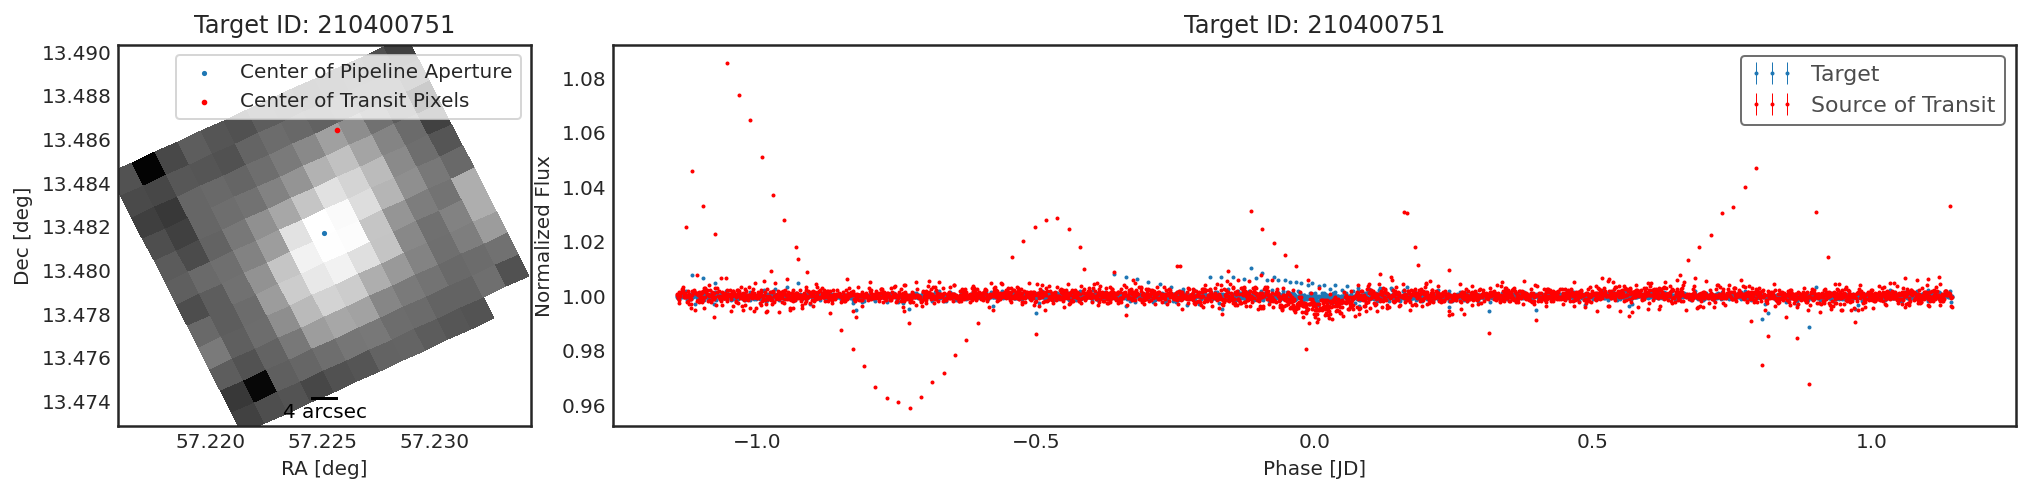

In [45]:
tpfs = lk.search_targetpixelfile("K2-78").download_all()
period = 2.29016
t0 = 2457065.1444 - 2454833
dur = 0.1204
result = ct.calculate_contamination(tpfs[0], period, t0, duration, plot=True, sff=True, windows=20, bins=10, spline_period=1., cbvs=True);

We can take a look at the best contaminante aperture and compare it to the pipeline aperture:

<AxesSubplot:title={'center':'contamainante'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

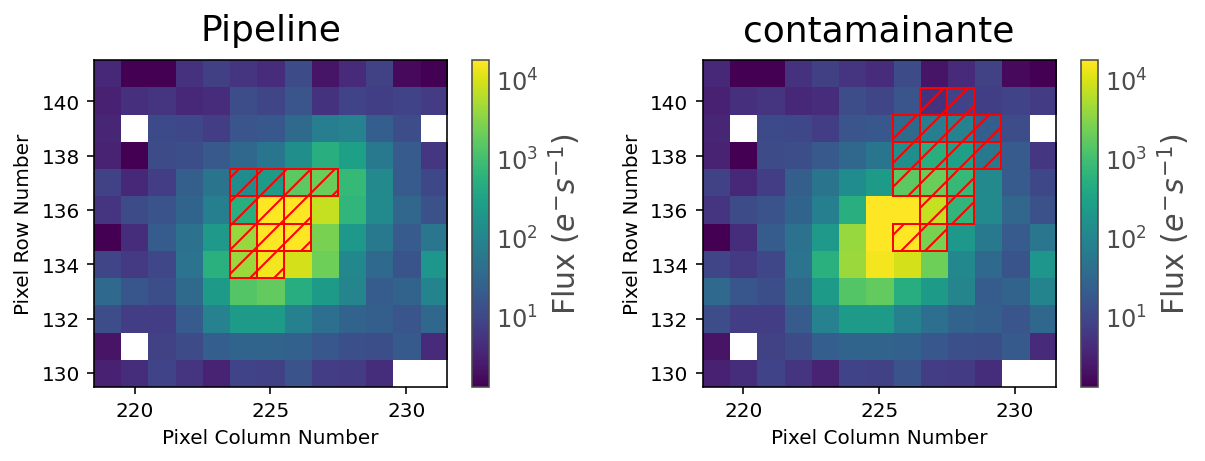

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
tpfs[0].plot(aperture_mask=tpfs[0].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
tpfs[0].plot(aperture_mask=result[0]['contaminator_aper'], scale='log', ax=ax[1], title='contamainante')

## Usage notes

1. **Different quarters, campaigns and sectors.** If a target has multiple quarters, campaigns or sectors you can expect each dataset to have some slight offset, due to the target falling on different pixels.

2. **Shallower contaminator light curves.** `Contaminante` looks at each pixel individually to see if there is a significant transit signal. Because faint pixels can contribute a transiting signal at a lower, less significant level, some faint pixels can be missed in contaminante. In the case that the contaminator light curve is **shallower** than the target light curve, it is likely that some faint pixels have been missed from the optimum aperture. This does not indicate that there is any contamination.

